## Модули

In [12]:
# Тюнинг
import optuna as opt
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures

%matplotlib inline

## Загрузка датасетов

In [13]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
test_df = pd.read_csv(TEST_DATASET)

# Сбалансированный (ТОЛЬКО ДЛЯ САБМИТА)
balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
train_df = balanced_df

# Выравнивание
first_negatives = train_df[train_df['y'] == 0][:train_df[train_df['y'] == 1]['y'].count()]
train_df = pd.concat([train_df[train_df['y'] == 1], first_negatives])

# Нормализация всего тренировочного (ТОЛЬКО ДЛЯ САБМИТА)
train_df = train_df[train_df['Длительность'] < 400]
train_df = train_df[(train_df['Сумма'] > 2) & (train_df['Сумма'] < 10)]
train_df = train_df[train_df['До поставки'] < 300]
train_df = train_df[train_df['Дней между 0_1'] < 400]
train_df = train_df[train_df['Количество изменений после согласований'] < 2000]
train_df = train_df[train_df['Количество'] < 300000]

X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Нормализация для кв/тестов
X_train = pd.concat([X_train, y_train], axis=1)

X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

## Списки признаков

In [14]:
# Категориальные фичи
cat_features = [
    'Purchasing Organization', 
    'Company Code', 'Provider', 
    'Provider Purchaser', 'Operations Manager', 'Sum Fold',
    'Material Group',
    'Purchasing Group', 'EI', 
    ]

# Фичи на масштабирование
scale_features = [
    'Position Count', 'Duration', 'ETC Delivery',
    'Changes After Approvals', 'Order Approval 1', 'Order Approval 2',
    'Order Approval 3', 'Sum', 'Change Delivery Date 7', 'Change Delivery Date 15', 
    'Change Delivery Date 30', 'Approval Cycles',
    'Handlers 7', 'Handlers 15', 'Handlers 30',
    'Days Between 0_1', 'Days Between 1_2', 'Days Between 2_3', 
    'Days Between 3_4', 'Days Between 4_5',
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8',
    'ETC Difference', 'ETC Power'
]

# Фичи на дроп
drop_features = [
    'Material', 'Cancel Complete Release', 'Month1', 'Month2', 'Month3',
    'Delivery Date', 'Change on Paper', 'Amount',
    'Category Manager', 'NRP', 'Provider Delivery option'
    ]

# Новые имена фич
rename_cols = [
    'Provider', 'Material', 'Category Manager', 'Operations Manager',
    'Factory', 'Purchasing Organization', 'Purchasing Group', 
    'Company Code', 'EI', 'Material Group', 'Delivery Option', 'NRP',
    'Duration', 'ETC Delivery', 'Month1', 'Month2', 'Month3', 'Weekday',
    'Sum', 'Position Count', 'Amount', 'Handlers 7', 'Handlers 15', 
    'Handlers 30', 'Order Approval 1', 'Order Approval 2', 'Order Approval 3',
    'Change Delivery Date 7', 'Change Delivery Date 15', 'Change Delivery Date 30',
    'Cancel Complete Release', 'Change on Paper', 'Delivery Date', 
    'Approval Cycles', 'Changes After Approvals', 'Days Between 0_1', 
    'Days Between 1_2', 'Days Between 2_3', 'Days Between 3_4', 'Days Between 4_5', 
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8'
    ]

## Препроцессор

In [15]:
# Препроцессоры
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """ Предобработчик данных """
    def __init__(self, cat_features, scale_features,
                 drop_features, rename_cols, transform_train=True):
        self.transform_train = transform_train
        self.cat_features = cat_features

        self.bin_encoder = BinaryEncoder(cols=cat_features)
        self.robust_scaler = RobustScaler()

        self.rename_cols = rename_cols

        self.drop_features = drop_features
        self.scale_features = scale_features

    def fit(self, X, y=None):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols
        
        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2
        
        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        self.robust_scaler.fit(X_[self.scale_features])
        # Категориальные фичи        
        X_ = self.bin_encoder.fit_transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)
        
        return self
    
    def transform(self, X):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2

        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        X_[self.scale_features] = self.robust_scaler.transform(X_[self.scale_features])

        # Категориальные фичи
        X_ = self.bin_encoder.transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)

        return X_

## Тюнинг

In [ ]:
# Функция оптимизации
def objective(trial: opt.Trial):
    # Параметры
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    n_estimators = trial.suggest_int('n_estimators', 1300, 3000)
    max_depth = trial.suggest_int('max_depth', 6, 21)
    max_bin = trial.suggest_int('max_bin', 64, 200),
    num_leaves = trial.suggest_int('num_leaves', 32, 260)
    reg_lambda = trial.suggest_float('l2_reg', 0.01, 1)

    # Модель
    data_preprocessor = DataPreprocessor(cat_features, scale_features, drop_features, rename_cols)
    model = LGBMClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        reg_lambda=reg_lambda,
        max_bin=max_bin,
        # n_jobs=-1,
        force_col_wise=True
    )

    pipeline = Pipeline([
        ('data_preproc', data_preprocessor),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
    accuracy = cv_score.mean()

    return accuracy

In [ ]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

## Тесты

In [19]:
best_params = {
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Модель
data_preprocessor = DataPreprocessor(cat_features, scale_features, drop_features, rename_cols)
poly = PolynomialFeatures()
model = LGBMClassifier(
    **best_params,
    n_jobs=-1,
    force_col_wise=True,
    # is_unbalance=True,
    objective='binary'
)

pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

### Кросс-валидация

In [ ]:
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean CV: {cv_scores.mean()}')

In [ ]:
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean CV: {cv_scores.mean()}')

### Валидация

In [9]:
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28431, number of negative: 169286
[LightGBM] [Info] Total Bins 2657
[LightGBM] [Info] Number of data points in the train set: 197717, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143796 -> initscore=-1.784109
[LightGBM] [Info] Start training from score -1.784109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [10]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9051778685449272
0.8895133437990581


In [ ]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

In [ ]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

              precision    recall  f1-score   support

           0    0.96631   0.98154   0.97387     18850
           1    0.87950   0.79749   0.83649      3185

    accuracy                        0.95494     22035
   macro avg    0.92291   0.88951   0.90518     22035
weighted avg    0.95377   0.95494   0.95401     22035



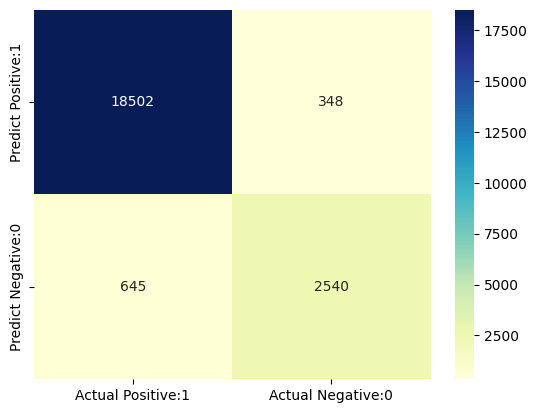

In [11]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],  
                                 index=['Predict Positive:1', 'Predict Negative:0']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

In [ ]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],  
                                 index=['Predict Positive:1', 'Predict Negative:0']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

### Важность признаков

In [ ]:
feature_importances = pd.DataFrame({'Feature': pipeline['model'].feature_name_, 'Importance': pipeline['model'].feature_importances_})
feature_importances.to_csv('features.csv', index=False)

## Финальный фит-предикт

In [20]:
pipeline.fit(X_general, y_general)
save_submission(pipeline, 'submission')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 189642, number of negative: 188073
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 377715, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502077 -> initscore=0.008308
[LightGBM] [Info] Start training from score 0.008308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
